# Snooker balls tracking on video

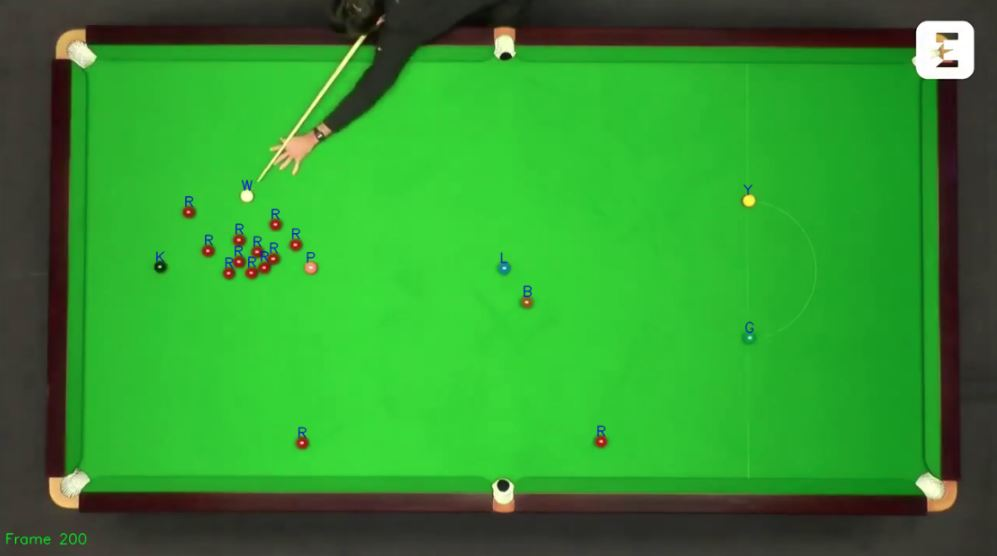









I created this notebook to prepare a label set to train  Mask R-CNN network. However, even though the solution is 
not ideal, it can be used to track multi-colored balls in snooker (and some other kinds of billiards). So I decided to publish it just for fun.<br>

**Video source:  [www.eurosport.co.uk](https://www.eurosport.co.uk/snooker/scottish-open/2020-2021/scottish-open-snooker-2020-watch-amazing-overhead-view-of-ronnie-o-sullivan-s-sublime-127-clearance_vid1391083/video.shtml)**<br>
It was not easy to find good quality video, captured by stationary overhead camera, so I took actually the one vieo I find - amazing 127 score clearance by RONNIE O'SULLIVAN at Scottish Open 2020

### The algorithm
- First I manually crop templates (patterns) for each ball's color (for example, the initial frame of the video can be used)<br>
Next steps are repiating for each frame:
- Video frame is converting to grayscale
- The script searches for balls (patterns) on a **grayscale picture** using openCV TemplateMatching 
- For each found ball its color is determined
- According to the defined colors and coordinates, each ball is marking with a letter<br>

*Black ball marked as blac**K**, blue - as b**L**ue, brown - as **B**rown*

###  What didn't work:
* Color template matching worked worse and significally slower
* Blur helped to detect motion balls more effectively, but missed for balls standing close to each other (which is espesially usual for reds in snooker)
* Histigram equalization didn't help as well
* Simple color segmentation worked perfect for 'single-color' balls, but was totally ineffective for reds
* The same for contours finding: it was a nightmare to separate red balls stayed close to each other

So finally *at any given time* we know the coordinates of all balls and know its color.<br>
I am demonstrating only balls tracking, but knowing the coordinates of the balls at any given time you can add any necessary logic - the movement of balls, collision, hitting the pocket, the speed, the distance traveled, etc.<br>

As you can see the solution doesn't work qith 100% accuracy, but that's why I'm going to try a Mask R-CNN to do the same job. The main artifacts occur when the balls are moving at high speed (right after the hit) and there are also a few ball color detection fouls.

In [1]:
!pip install imutils
import imutils
from imutils.object_detection import non_max_suppression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import time

  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=19e6f17b8118f53c6cee8b6b3af14904867d961f298fdf2ded77533d58bfb2ee
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


This is a helper function to show images in jupyter notebooks

In [2]:
def show(image,H = 20, W = 15):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (H, W))
    plt.xticks([]), plt.yticks([])
    if len(image.shape) == 2:
        plt.imshow(image, cmap = 'gray')
    else:
        plt.imshow(image)
    plt.show()
    
    
def show_multi (imgs, H=5, W=5):
    stack = imgs[0]
    for i in range(1, len(imgs)):
        stack = np.hstack((stack, imgs[i]))
    show(stack, H, W)

This mask I've created manually in Photoshop. It is using to select only the area of interest (the playing area of the table)

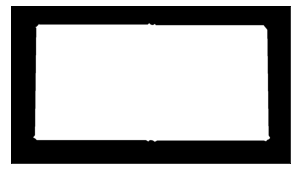

In [3]:
table_mask = cv2.imread('../input/snooker-scottish-open/pool-table-mask_1280_720.bmp')
table_mask = table_mask[:,:,0]
show(table_mask, 5)

This function is importing video stream and select single frame (frame #100 in this case) I will use to create patterns.

In [4]:
def get_frame(num):
    counter = 0
    vs = cv2.VideoCapture('../input/snooker-scottish-open/Ronnie OSullivan 127 Break Total Clearance - Full table TV camera  x1.5 Speed (Scottish Open 2020).mp4')
    while True:
        frame = vs.read()
        frame = frame[1]
        if frame is None:
            print('No frame')
            return
        if counter == num:
            return frame
        counter +=1

template_img = get_frame(100)

Here I manualy create (slice from single frame) patterns for every color

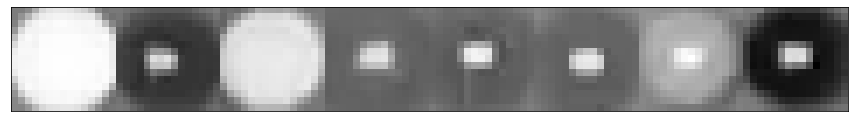

In [5]:
img = template_img.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

b = 0 # bias (not used)

white  = img[448+b:463-b, 244+b:259-b]
red    = img[273+b:288-b, 238+b:253-b]
yellow = img[256+b:271-b, 951+b:966-b]
green  = img[431+b:446-b, 952+b:967-b]
brown  = img[386+b:401-b, 668+b:683-b]
blue   = img[342+b:357-b, 639+b:654-b]
pink   = img[342+b:357-b, 393+b:408-b]
black  = img[295+b:310-b, 213+b:228-b]

templates = [white, red, yellow, green, brown, blue, pink, black]

show_multi(templates, 15, 15)

As you can see some colors looks almost similiar in grascale, that's why I will detect balls in groups:
* Black, red, brown and blue  (red pattern)
* White and yellow (white pattern)
* Green
* Pink

This function is getting 15x15 px templates and returning coordinates of balls for each group

In [6]:
def track(clone, template, thrs):
    (tH, tW) = (15,15)
    result = cv2.matchTemplate(clone, template,cv2.TM_CCOEFF_NORMED)
    (yCoords, xCoords) = np.where(result >= thrs)
    
    rects = []
    for (x, y) in zip(xCoords, yCoords):
        rects.append((x, y, x + tW, y + tH))
    pick = non_max_suppression(np.array(rects))
    return pick

This function is detecting color. The algoritрm is very simple: color can be separated by the **median** of BGR picture, I didn't even convert images to HSV to increase the speed.<br>
The fuction returns dataframe with all balls in a group, its color and X Y coordinates

In [7]:
def get_color (frame, coords, color_set):
    df = pd.DataFrame(columns = ['color', 'x', 'y'])
    counter = 0
    for c in coords:
        
        img = frame[c[1] : c[3], c[0]:c[2]]
        median = np.median(img)
        
        if color_set == 'DARK':
            if median < 40:
                color = 'K' # blacK
            elif 40 <= median < 85:    
                color = 'R' # Red
            elif 85 <= median < 110:    
                color = 'B' # Brown
            elif median >= 110:    
                color = 'L' # bLue

        if color_set == 'LIGHT':
            if median >= 205:
                color = 'W' # White
            elif median < 205:    
                color = 'Y' # Yellow
            
        if color_set == 'GREEN':
            color = 'G' # Green

        if color_set == 'PINK':
            color = 'P' # Pink
        
        df.loc[counter, 'color'] = color
        df.loc[counter, 'x'] = c[0]
        df.loc[counter, 'y'] = c[1]
        
        counter += 1
    return df

This simple function is just drawing the letter close to each ball in accordance with data from the dataframe

In [8]:
def type_color (frame, df):
    clone = frame.copy()
    for i in range(len(df)):
        cv2.putText(clone,
            df.loc[i,'color'],
            org = (df.loc[i,'x'], df.loc[i,'y']),
            fontFace = cv2.FONT_HERSHEY_SIMPLEX,
            fontScale = 0.6,
            color = (255, 0, 0),
            thickness = 1,
            lineType= cv2.LINE_AA)
        
    return clone

And this is the main fuction that is:
* opening the video stream
* preprocessing each frame (BGR to GRAYSCALE and table mask)
* applying all functions one by one
* recording the video

In [9]:
%%time
#Open video stream
vs = cv2.VideoCapture('../input/snooker-scottish-open/Ronnie OSullivan 127 Break Total Clearance - Full table TV camera  x1.5 Speed (Scottish Open 2020).mp4')

#Initiate video recorder
fourcc = cv2.VideoWriter_fourcc(*"MJPG")
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (1280,720))

#Processing
while True:
    frame = vs.read()
    frame = frame[1]
    
    #Stop if video is over
    if frame is None:
        break
    
    #Clone each frame and preprocess
    clone = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2GRAY)
    clone = cv2.bitwise_and(clone, clone, mask = table_mask)
    
    #Calculate balls coordinates
    light_coord  = track(clone, white, 0.9)  # White and Yellow balls
    dark_coord   = track(clone, red,   0.8)  # Red, blacK, Brown and bLue balls
    green_coord  = track(clone, green, 0.95) # Green ball
    pink_coord   = track(clone, pink,  0.95) # Pink ball
    
    #Color detection
    a = get_color(frame, dark_coord,  color_set = 'DARK')
    b = get_color(frame, light_coord, color_set = 'LIGHT')
    c = get_color(frame, green_coord, color_set = 'GREEN')
    d = get_color(frame, pink_coord,  color_set = 'PINK')
    
    #Dataframe with all balls
    balls_df = pd.concat([a,b,c,d]).reset_index(drop = True)
    
    #Draw letters 
    frame = type_color(frame, balls_df)
   
    #Write the modified frame
    out.write(frame)

out.release()

print ('Complete')

Complete
CPU times: user 8min 1s, sys: 1min 46s, total: 9min 47s
Wall time: 9min 17s


If you dont want to run the notebook or download the final video from outputs, the video is also available  [**here**](https://disk.yandex.ru/i/FU1KcqoZdL1gkw) in online veiwer

#### Thank you for your attention !
If you know any similiar video sources (billiard captured on a stationary overhead camera), **please** let me know in comments